In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
df = pd.read_csv('Reviews.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [4]:
filtered_data=df[df['Score']!=3]
filtered_data = filtered_data.head(100000)

def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [7]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [8]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

In [9]:
import nltk
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
print(stop)

{"you've", 'doing', 'not', "isn't", 'was', 'off', "you'd", 'should', 'this', 'further', "needn't", "hasn't", 'until', "you'll", 'me', 'myself', 'if', 'didn', 'yourselves', 'and', 'just', 'shan', 'into', 'do', 'theirs', 'any', 'no', 'down', 'more', 'through', "mustn't", 'its', 'it', 'being', 'the', 'most', 'before', 'don', 'doesn', 'he', 'some', 'does', 'themselves', "mightn't", 'having', 'she', 'ma', 'is', 'during', 'hadn', 've', 'their', 'than', 'his', 'against', 'm', 'when', 'nor', 'had', 'yourself', 'did', 'here', 'couldn', 'd', 'where', "should've", 'hasn', "hadn't", "doesn't", "won't", "didn't", 'can', 'we', 'each', 'own', 'i', 'have', 'of', 'then', 'will', 'other', 'weren', 'whom', 'a', 'my', 'ourselves', "weren't", 'am', 'itself', "it's", 'above', "don't", 'that', 'under', 'ain', 'which', "she's", 'isn', "wasn't", 'too', 'those', "shouldn't", 'himself', 'there', 's', 'again', 'below', 'won', 'or', "aren't", "that'll", 'your', 'once', 'but', 'after', 'same', 'yours', 'wasn', 'are

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import numpy
import re
from bs4 import BeautifulSoup
stop=set(stopwords.words('english'))
snow = nltk.stem.SnowballStemmer('english')
stop
def decontracted(phrase):
    phrase=re.sub(r"won't","will not",phrase)
    phrase=re.sub(r"can't","can not",phrase)
    phrase=re.sub(r"n\'t","not",phrase)
    phrase=re.sub(r"\'re","are",phrase)
    phrase=re.sub(r"\'s","is",phrase)
    phrase=re.sub(r"\'d","would",phrase)
    phrase=re.sub(r"\'ll","will",phrase)    
    phrase=re.sub(r"\'t","not",sentence)
    phrase=re.sub(r"\'ve","have",sentence)
    phrase=re.sub(r"\'m","am",sentence)
    return phrase
preprocessed_reviews=[]
for sentence in final['Text'].values:
    sentence=re.sub(r"http\S+"," ",sentence)
    sentence=BeautifulSoup(sentence,'lxml').get_text()
    cleanr=re.compile('<.*?>')
    sentence=re.sub(cleanr,' ',sentence)
    sentence=decontracted(sentence)
    sentence=re.sub("\S\*\d\S*"," ",sentence)
    sentence=re.sub("[^A-Za-z]+"," ",sentence)
    sentence=re.sub(r'[?|!|\'|"|#]',r' ',sentence)
    sentence=re.sub(r'[.|,|)|(|\|/]',r' ',sentence)
    sentence='  '.join(snow.stem(e.lower()) for e in sentence.split() if e.lower() not in stop)
    preprocessed_reviews.append(sentence.strip())

In [11]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abdomin', 'abil', 'abl', 'abl add', 'abl brew', 'abl buy']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 53660)
the number of unique words including both unigrams and bigrams  53660


In [12]:
#Splitting preprocessed reviews into train,cross validation and test
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection  import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection  import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
X=preprocessed_reviews

y=np.array(final['Score'])
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
X_train, X_cv, y_train, y_cv = train_test_split(X_1, y_1, test_size=0.2)

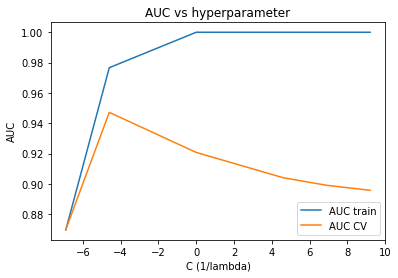

optimal lambda for which auc is maximum :  99.0


In [15]:
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
X_train_tf=tf_idf_vect.fit_transform(X_train)
X_cv_tf=tf_idf_vect.transform(X_cv)
X_test_tf=tf_idf_vect.transform(X_test)

scalar = StandardScaler(with_mean=False)
X_train_tf = scalar.fit_transform(X_train_tf)
X_test_tf= scalar.transform(X_test_tf)
X_cv_tf=scalar.transform(X_cv_tf)

C = [10**-3, 10**-2, 10**0, 10**2,10**3,10**4]#C=1/lambda
auc_train=[]
auc_cv=[]
for c in C:
    lr=LogisticRegression(penalty='l1',C=c,solver='liblinear')
    lr.fit(X_train_tf,y_train)
    probcv=lr.predict_proba(X_cv_tf)[:,1]
    auc_cv.append(roc_auc_score(y_cv,probcv))
    probtr=lr.predict_proba(X_train_tf)[:,1]
    auc_train.append(roc_auc_score(y_train,probtr))
optimal_c= C[auc_cv.index(max(auc_cv))]
C=[math.log(x) for x in C]#converting values of C into logarithm
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(C, auc_train, label='AUC train')
ax.plot(C, auc_cv, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('C (1/lambda)')
plt.ylabel('AUC')
ax.legend()
plt.show()
print('optimal lambda for which auc is maximum : ',1//optimal_c)

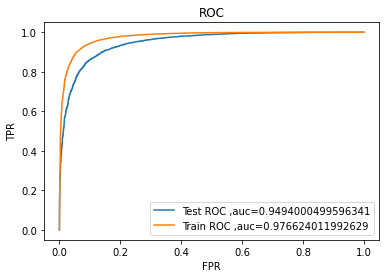

In [17]:
lr=LogisticRegression(penalty='l1',C=optimal_c,solver='liblinear')
lr.fit(X_train_tf,y_train)
predi=lr.predict_proba(X_test_tf)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred=lr.predict_proba(X_train_tf)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,pred)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

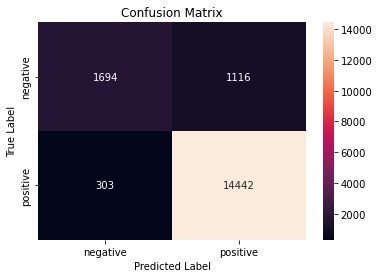

In [72]:
from sklearn.metrics import confusion_matrix
lr=LogisticRegression(penalty='l1',C=optimal_c,solver='liblinear')
lr.fit(X_train_tf,y_train)
predic=lr.predict(X_test_tf)
import seaborn as sns
conf_mat = confusion_matrix(y_test, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

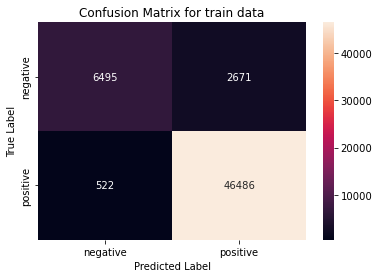

In [73]:
from sklearn.metrics import confusion_matrix

predic=lr.predict(X_train_tf)
import seaborn as sns
conf_mat = confusion_matrix(y_train, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

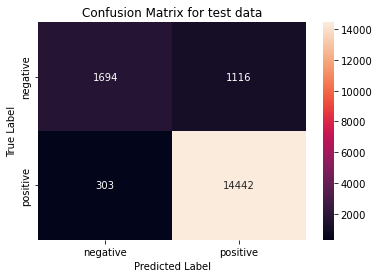

In [74]:
#confusion matrix for test data
#Confusion matrix using heatmap for test data
from sklearn.metrics import confusion_matrix

predic=lr.predict(X_test_tf)
import seaborn as sns
conf_mat = confusion_matrix(y_test, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [75]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='l1',C=optimal_c,solver='liblinear')
model.fit(X_train_tf, y_train)

LogisticRegression(C=0.01, penalty='l1', solver='liblinear')

In [76]:
y_pred = model.predict(X_test_tf)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [77]:
#Confusion Matrix 
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 1694,  1116],
       [  303, 14442]])

In [78]:
#Finding Accuracy 
from sklearn.metrics import accuracy_score
print ("Accuracy : ", accuracy_score(y_test, y_pred))

Accuracy :  0.9191683281116491


In [79]:
# Finding precision 
from sklearn.metrics import precision_score
precision_score(y_test, y_pred)

0.9282684149633629

In [80]:
# Finding recall
from sklearn.metrics import  recall_score
recall_score(y_test, y_pred)

0.9794506612410987

In [81]:
# computing the F1 score : 
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.9531729531729533